# INF283 | Weekly Exercise 07 | Dimensionality Reduction
​
#### Deadline
November 9, 2018 | 23:59
​
#### What to deliver 
You can try out your Python code within this notebook. But you should <font color="#b51555">make a PDF file of answers for each of the tasks, and then submit this PDF file </font>on Mitt UiB.  <font color="#b51555">**Do not submit the complete notebook; it makes it difficult for the graders to locate your answers in the lengthy Jupyter notebook. **</font>
​
#### Where to deliver
On [Mitt UiB](https://mitt.uib.no/courses/12791/assignments) in the assignments section.
​

# 1. Principal Component Analysis from scratch
### Introduction
The sheer size of data in the modern age is not only a challenge for computer hardware but also a main bottleneck for the performance of many machine learning algorithms. Often, the desired goal is to reduce the dimensions of a $d$-dimensional dataset by projecting it onto a $(k)$-dimensional subspace (where $k\;<\;d$) in order to increase the computational efficiency while retaining most of the information.

PCA aims to detect the correlation between variables. If a strong correlation between variables exists, then an attempt to reduce the dimensionality only makes sense. In a nutshell, this is what PCA is all about: Finding the directions of maximum variance in high-dimensional data and projecting it onto a smaller dimensional subspace while retaining most of the information.

In PCA, we compute eigenvectors (the principal components) of a dataset and collect them in a projection matrix. Each of those eigenvectors is associated with an eigenvalue which can be interpreted as the "length" or "magnitude" of the corresponding eigenvector. If some eigenvalues have a significantly larger magnitude than others, then the reduction of the dataset via PCA onto a smaller dimensional subspace by dropping the *less informative* eigenpairs is reasonable.

Summary of PCA algorithm
*  Standardize the data.
*  Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix, or perform Singular Vector Decomposition.
*  Sort eigenvalues in descending order and choose the  𝑘  eigenvectors that correspond to the  𝑘  largest eigenvalues where  𝑘  is the number of dimensions of the new feature subspace ( 𝑘 < 𝑑 ).
*  Construct the projection matrix  𝐖  from the selected  𝑘  eigenvectors.
*  Transform the original dataset  𝐗  via  𝐖  to obtain a  𝑘 -dimensional feature subspace  𝐘 .





### Iris Dataset
We will use the Iris dataset for explaining PCA. We used this dataset in exercise 02 as well. 

As you may know, Iris dataset is already available in sklearn and Pandas, but let us show how you can download and use it from the UCI repository. Any other dataset from UCI repository can be read in the same way. Datasets in UCI are present in .data file, which is nothing but a comma-separated file (csv).

In [1]:
import pandas as pd

df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
    header=None, 
    sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how="all", inplace=True) # drops the empty line at file-end

df.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


Now we split the data table into data X and class labels y:


In [2]:
X = df.ix[:,0:4].values;
y = df.ix[:,4].values;

/Users/Sathiesh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Our iris dataset is now stored in form of a  $150 \times 4$ matrix where the columns are the different features, and every row represents a separate flower sample.
Each sample row $\mathbf{x}$ can be pictured as a 4-dimensional vector   


$\mathbf{x^T} = \begin{pmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{pmatrix} 
= \begin{pmatrix} \text{sepal length} \\ \text{sepal width} \\\text{petal length} \\ \text{petal width} \end{pmatrix}$

### Exploratory Visualization
To get a feeling for how the 3 different flower classes are distributes along the 4 different features, let us visualize them via histograms.


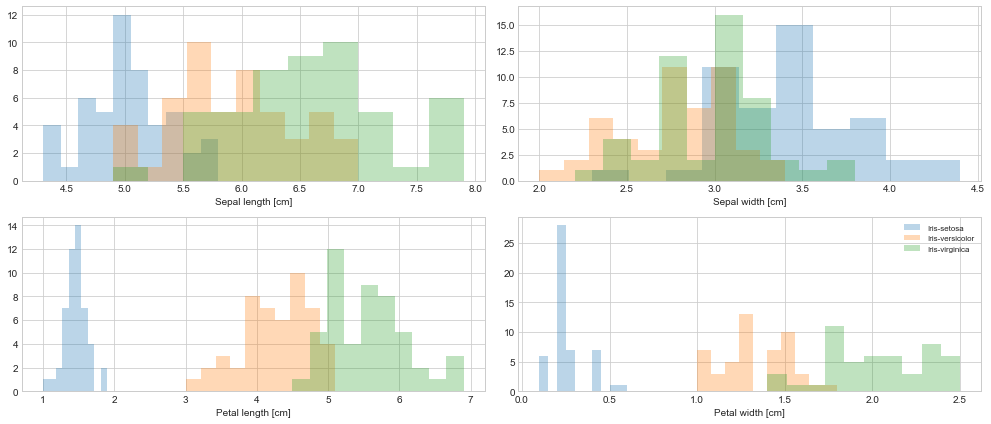

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import math

def plot_histograms(X, y):
  label_dict = {1: 'Iris-Setosa',
                2: 'Iris-Versicolor',
                3: 'Iris-Virgnica'}

  feature_dict = {0: 'Sepal length [cm]',
                  1: 'Sepal width [cm]',
                  2: 'Petal length [cm]',
                  3: 'Petal width [cm]'}

  with plt.style.context('seaborn-whitegrid'):
      plt.figure(figsize=(14, 6))
      for cnt in range(4):
          plt.subplot(2, 2, cnt+1)
          for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
              plt.hist(X[y==lab, cnt],
                       label=lab,
                       bins=10,
                       alpha=0.3,)
          plt.xlabel(feature_dict[cnt])
      plt.legend(loc='upper right', fancybox=True, fontsize=8)

      plt.tight_layout()
      plt.show()

plot_histograms(X, y)

### Standardizing
Whether to standardize the data prior to a PCA on the covariance matrix depends on the measurement scales of the original features. Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. Although, all features in the Iris dataset were measured in centimeters, let us continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms.

Below we will standarize the data, and then plot the histograms again to see the effect of standardization:

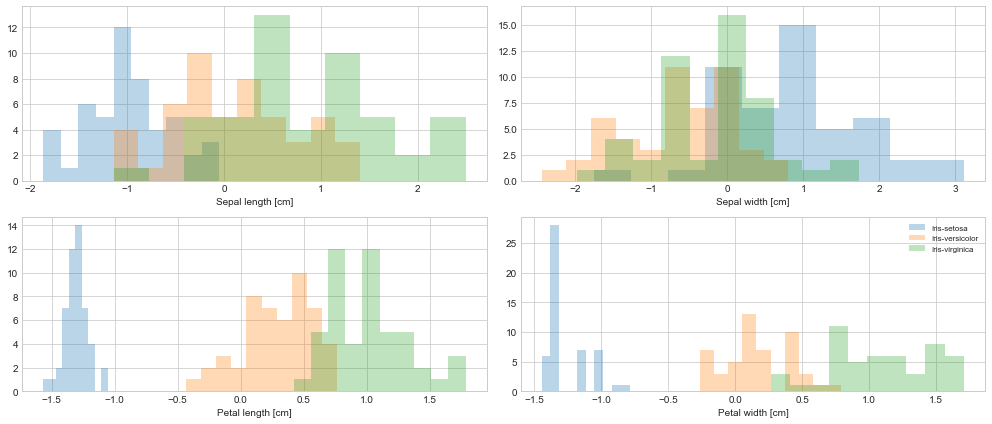

In [4]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
plot_histograms(X_std, y)

### Eigendecomposition - Computing Eigenvectors and Eigenvalues
The eigenvectors and eigenvalues of a covariance (or correlation) matrix represent the "core" of a PCA: The eigenvectors (principal components) determine the directions of the new feature space, and the eigenvalues determine their magnitude. In other words, the eigenvalues explain the variance of the data along the new feature axes.

The classic approach to PCA is to perform the eigendecomposition on the covariance matrix $\Sigma$, which is a $d \times d$ matrix where each element represents the covariance between two features. The covariance between two features is calculated as follows:

$\sigma_{jk} = \frac{1}{n-1}\sum_{i=1}^{N}\left(  x_{ij}-\bar{x}_j \right)  \left( x_{ik}-\bar{x}_k \right).$

We can summarize the calculation of the covariance matrix via the following matrix equation:   
$\Sigma = \frac{1}{n-1} \left( (\mathbf{X} - \mathbf{\bar{x}})^T\;(\mathbf{X} - \mathbf{\bar{x}}) \right)$  
where $\mathbf{\bar{x}}$ is the mean vector 
$\mathbf{\bar{x}} = \sum\limits_{i=1}^n x_{i}.$  
The mean vector is a $d$-dimensional vector where each value in this vector represents the sample mean of a feature column in the dataset.

In [5]:
import numpy as np
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print("Covariance matrix: \n%s" %cov_mat )

Covariance matrix: 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


The more verbose way above was simply used for demonstration purposes; equivalently, we could have used the numpy  to get the same result in just a single line of code.

---


## <font color="#b51555">Exercise 1.1
Using numpy, calculate the covariance of `X_std`.
<font>

---

In [6]:
cov_mat = np.cov(X_std.T)

Next, we perform an eigendecomposition on the covariance matrix:


In [7]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.93035378 0.92740362 0.14834223 0.02074601]


### Selecting Principal Components

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [8]:
for ev in eig_vecs.T:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


#### Sorting the eigen values
In order to decide which eigenvector(s) can dropped without losing too much information
for the construction of lower-dimensional subspace, we need to inspect the corresponding eigenvalues: The eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data; those are the ones can be dropped.  
In order to do so, the common approach is to rank the eigenvalues from highest to lowest in order choose the top $k$ eigenvectors.

In [9]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
2.9303537755893156
0.9274036215173417
0.1483422264816399
0.02074601399559615


#### Explained variance
After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

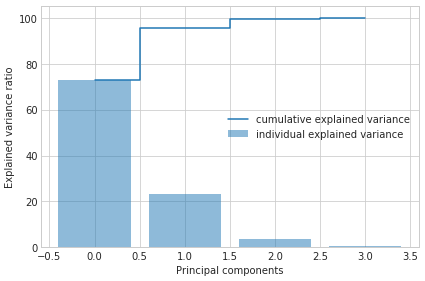

In [10]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(4), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.show()

The plot above clearly shows that most of the variance (72.77% of the variance to be precise) can be explained by the first principal component alone. The second principal component still bears some information (23.03%) while the third and fourth principal components can safely be dropped without losing to much information. Together, the first two principal components contain 95.8% of the information.

#### Making a projection matrix
The projection matrix that will be used to transform the Iris data onto the new feature subspace. Although, the name "projection matrix" sounds fancy, it is basically just a matrix of our concatenated top k eigenvectors.

Here, we are reducing the 4-dimensional feature space to a 2-dimensional feature subspace, by choosing the "top 2" eigenvectors with the highest eigenvalues to construct our  𝑑×𝑘 -dimensional eigenvector matrix  𝐖 .

In [11]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1), 
                      eig_pairs[1][1].reshape(4,1)))

print('Matrix W:\n %s' %matrix_w)

Matrix W:
 [[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


### Projection Onto the New Feature Space
In this last step we will use the $4 \times 2$-dimensional projection matrix $\mathbf{W}$ to transform our samples onto the new subspace via the equation:

$\mathbf{Y} = \mathbf{X} \times  \mathbf{W}$

where $\mathbf{Y}$ is a $150\times 2$ matrix of our transformed samples.

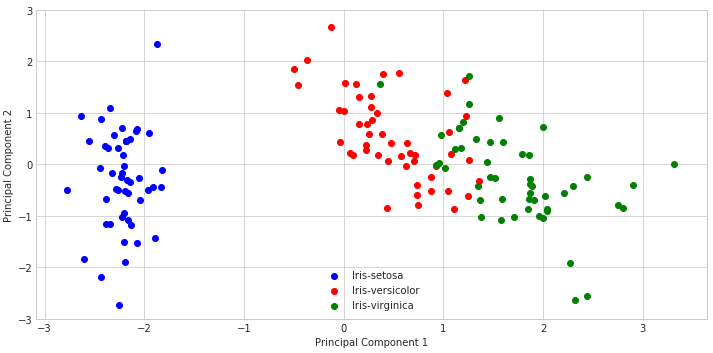

In [12]:
Y = X_std.dot(matrix_w)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 5))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
plt.show()

## PCA using scikit-learn

In [13]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

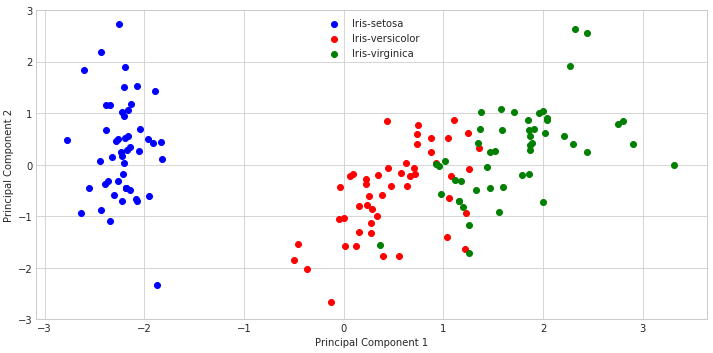

In [14]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 5))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y_sklearn[y==lab, 0],
                    Y_sklearn[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='upper center')
    plt.tight_layout()
plt.show()

---


## <font color="#b51555">Exercise 1.2
We saw previously that the first principal component explains about 72% of the variance, whereas the second principal component explains 23% of the variance. Write sklearn code to extract these percentages.
<font>



In [15]:
sklearn_pca.explained_variance_ratio_

array([0.72770452, 0.23030523])



## <font color="#b51555">Exercise 1.3
If you observe closely, you will notice that the plot of principal component 1 vs. principal component 2 obtained using sklearn is different than that obtained by the PCA that we did manually. More specifically, you will observer that the principal component 2 obtained with sklearn is a flipped version of principal component 2 obtained with manual PCA. Can you think of a a reason why this is happening?

<font>

---

# Answer 
Eigenvectors are represented oppsite from each other. 

# 2. Kernel PCA
The “classic” PCA approach described above is a linear projection technique that works well if the data is linearly separable. However, in the case of linearly inseparable data, a nonlinear technique is required if the task is to reduce the dimensionality of a dataset.
![alt text](https://sebastianraschka.com/images/blog/2014/kernel_pca/linear_vs_nonlinear.png)


The basic idea to deal with linearly inseparable data is to project it onto a higher dimensional space where it becomes linearly separable. Let us call this nonlinear mapping function ϕ so that the mapping of a sample x can be written as x→ϕ(x), which is called “kernel function.”

We will start with a simple example of 2 half-moon shapes generated by the make_moons function from scikit-learn.




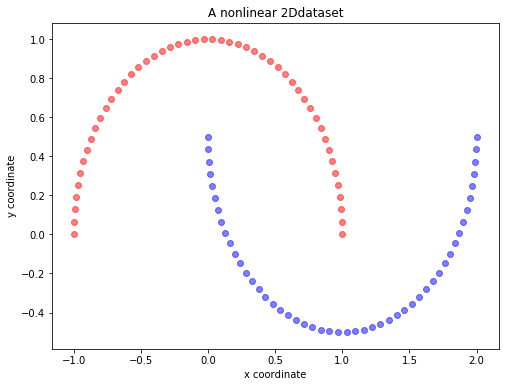

In [16]:
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)

plt.figure(figsize=(8,6))

plt.scatter(X[y==0, 0], X[y==0, 1], color='red', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', alpha=0.5)

plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

#### Linear PCA

Since the two half-moon shapes are linearly inseparable, we expect that the “classic” PCA will fail to give us a “good” representation of the data in 1D space. Here, we will use the PCA class that is implemented in scikit-learn to perform the dimensionality reduction.

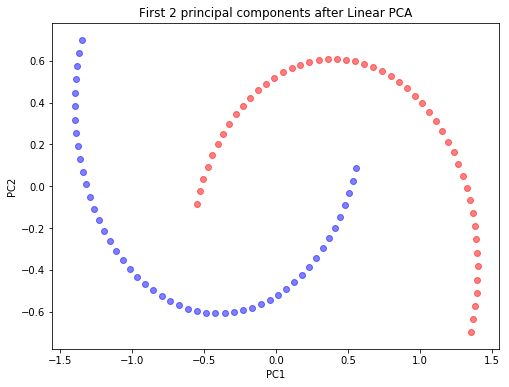

In [17]:
from sklearn.decomposition import PCA

scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', alpha=0.5)

plt.title('First 2 principal components after Linear PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

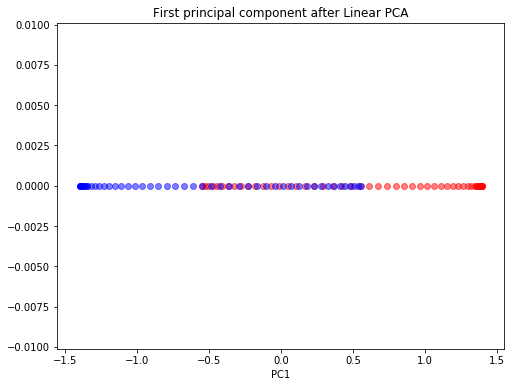

In [18]:
import numpy as np
scikit_pca = PCA(n_components=1)
X_spca = scikit_pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_spca[y==0, 0], np.zeros((50,1)), color='red', alpha=0.5)
plt.scatter(X_spca[y==1, 0], np.zeros((50,1)), color='blue', alpha=0.5)

plt.title('First principal component after Linear PCA')
plt.xlabel('PC1')

plt.show()

As we can see, the resulting principal components do not yield a subspace where the data is linearly separated well. Note that PCA is a unsupervised method and does not “consider” class labels in order to maximize the variance. Here, the colors blue and red are just added for visualization purposes to indicate the degree of separation.

#### Gaussian RBF kernel PCA

Next, we will perform dimensionality reduction via RBF kernel PCA on our half-moon data. 

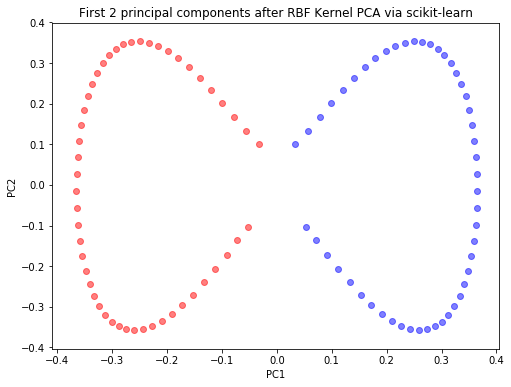

In [19]:
from sklearn.decomposition import KernelPCA

scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1], color='red', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], color='blue', alpha=0.5)

plt.title('First 2 principal components after RBF Kernel PCA via scikit-learn')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

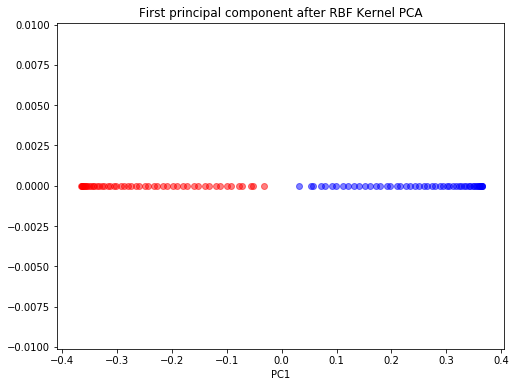

In [20]:
scikit_kpca = KernelPCA(n_components=1, kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_skernpca[y==0, 0], np.zeros((50,1)), color='red', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], np.zeros((50,1)), color='blue', alpha=0.5)
plt.title('First principal component after RBF Kernel PCA')
plt.xlabel('PC1')
plt.show()

---


## <font color="#b51555">Exercise 1.4
The code below generates a two-class data containing two concentric circles, i.e., a small circle inside a larger circle. Your task is to extend this code to and do the following:
  1. Plot the data such that plot shows the two concentric circles in two distinct colors
  2. Perform kernel PCA to find a 2-dimensional projection of this data such the projected data is linearly separable. 
  3. Plot the projected data in 2D.
<font>

---

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

np.random.seed(0)

X, y = make_circles(n_samples=400, factor=.3, noise=.05)

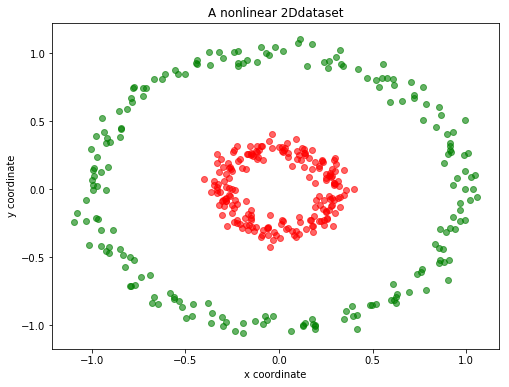

In [22]:
plt.figure(figsize=(8,6))

#alpha is used in order to better see the overlapping. 
plt.scatter(X[y==0, 0], X[y==0, 1], color='green', alpha=0.6)
plt.scatter(X[y==1, 0], X[y==1, 1], color='red', alpha=0.6)

plt.title('A nonlinear 2Ddataset')
plt.ylabel('y coordinate')
plt.xlabel('x coordinate')

plt.show()

In [23]:
from sklearn.decomposition import KernelPCA

scikit_kpca = KernelPCA(n_components=1, kernel='rbf', gamma=5)
X_skernpca = scikit_kpca.fit_transform(X)

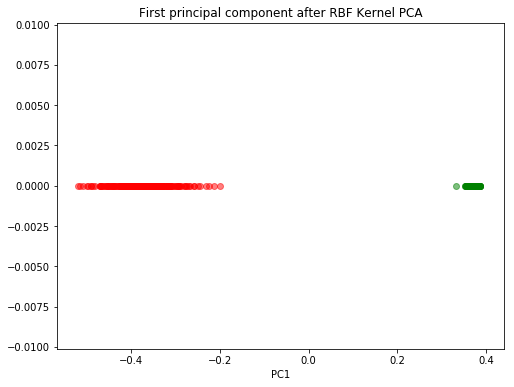

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(X_skernpca[y==0, 0], np.zeros((200,1)), color='green', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], np.zeros((200,1)), color='red', alpha=0.5)
plt.title('First principal component after RBF Kernel PCA')
plt.xlabel('PC1')
plt.show()

# 3. Movie recommendation system based on matrix factorization

Just as its name suggests, matrix factorization is to, obviously, factorize a matrix, i.e. to find out two (or more) matrices such that when you multiply them you will get back the original matrix.

As mentioned above, from an application point of view, matrix factorization can be used to discover latent features underlying the interactions between two different kinds of entities. (Of course, you can consider more than two kinds of entities and you will be dealing with tensor factorization, which would be more complicated.) And one obvious application is to predict ratings in collaborative filtering.

In a recommendation system such as Netflix or MovieLens, there is a group of users and a set of items (movies for the above two systems). Given that each users have rated some items in the system, we would like to predict how the users would rate the items that they have not yet rated, such that we can make recommendations to the users. In this case, all the information we have about the existing ratings can be represented in a matrix. Assume now we have 5 users and 4 items, and ratings are integers ranging from 1 to 5, the matrix may look something like this (a hyphen means that the user has not yet rated the movie):

|  | D1 | D2 | D3 | D4 |
|----|----|----|----|----|
| U1 | 5 | 3 | - | 1 |
| U2 | 4 | - | - | 1 |
| U3 | 1 | 1 | - | 5 |
| U4 | 1 | - | - | 4 |
| U5 | - | 1 | 5 | 4 |


Hence, the task of predicting the missing ratings can be considered as filling in the blanks (the hyphens in the matrix) such that the values would be consistent with the existing ratings in the matrix.

The intuition behind using matrix factorization to solve this problem is that there should be some latent features that determine how a user rates an item. For example, two users would give high ratings to a certain movie if they both like the actors/actresses of the movie, or if the movie is an action movie, which is a genre preferred by both users. Hence, if we can discover these latent features, we should be able to predict a rating with respect to a certain user and a certain item, because the features associated with the user should match with the features associated with the item.

In trying to discover the different features, we also make the assumption that the number of features would be smaller than the number of users and the number of items. It should not be difficult to understand this assumption because clearly it would not be reasonable to assume that each user is associated with a unique feature (although this is not impossible). And anyway if this is the case there would be no point in making recommendations, because each of these users would not be interested in the items rated by other users. Similarly, the same argument applies to the items.

#### The Maths of Matrix Factorization

Having discussed the intuition behind matrix factorization, we can now go on to work on the mathematics. Firstly, we have a set $U$ of users, and a set $D$ of items. Let $R$ of size $|U| \times |D|$ be the matrix that contains all the ratings that the users have assigned to the items. Also, we assume that we would like to discover $K$ latent features. Our task, then, is to find two matrics matrices $P$ (of size $|U| \times |K|$) and $Q$ (of size $|D| \times |K|$) such that their product apprioximates |R|:

$$\mathbf{R} \approx \mathbf{P} \times \mathbf{Q}^T = \hat{\mathbf{R}}$$

In this way, each row of $\mathbf{P}$ would represent the strength of the associations between a user and the features. Similarly, each row of $\mathbf{Q}$ would represent the strength of the associations between an item and the features. To get the prediction of a rating of an item $d_j$ by $u_i$, we can calculate the dot product of their vectors:

$$\hat{r}_{ij} = p_i^T q_j = \sum_{k=1}^k{p_{ik} q_{kj}}$$

Now, we have to find a way to obtain $\mathbf{P}$ and $\mathbf{Q}$. One way to approach this problem is the first intialize the two matrices with some values, calculate how different their product is to $\mathbf{M}$, and then try to minimize this difference iteratively. Such a method is called gradient descent, aiming at finding a local minimum of the difference.

The difference here, usually called the error between the estimated rating and the real rating, can be calculated by the following equation for each user-item pair:

$$e_{ij}^2 = (r_{ij} - \hat{r}_{ij})^2 = (r_{ij} - \sum_{k=1}^K{p_{ik}q_{kj}})^2$$

Here we consider the squared error because the estimated rating can be either higher or lower than the real rating.

To minimize the error, we have to know in which direction we have to modify the values of $p_{ik}$ and $q_{kj}$. In other words, we need to know the gradient at the current values, and therefore we differentiate the above equation with respect to these two variables separately:

$$\frac{\partial}{\partial p_{ik}}e_{ij}^2 = -2(r_{ij} - \hat{r}_{ij})(q_{kj}) = -2 e_{ij} q_{kj}$$
$$ \frac{\partial}{\partial q_{ik}}e_{ij}^2 = -2(r_{ij} - \hat{r}_{ij})(p_{ik}) = -2 e_{ij} p_{ik}$$

Having obtained the gradient, we can now formulate the update rules for both $p_{ik}$ and $q_{kj}$:

$$p’_{ik} = p_{ik} + \alpha \frac{\partial}{\partial p_{ik}}e_{ij}^2 = p_{ik} + 2\alpha e_{ij} q_{kj}$$
$$q’_{kj} = q_{kj} + \alpha \frac{\partial}{\partial q_{kj}}e_{ij}^2 = q_{kj} + 2\alpha e_{ij} p_{ik}$$

Here, $\alpha$ is a constant whose value determines the rate of approaching the minimum. Usually we will choose a small value for $\alpha$, say 0.1. This is because if we make too large a step towards the minimum we may run into the risk of missing the minimum and end up oscillating around the minimum.

A question might have come to your mind by now: if we find two matrices $\mathbf{P}$ and $\mathbf{Q}$ such that $\mathbf{P} \times \mathbf{Q}$ approximates $\mathbf{R}$, isn’t that our predictions of all the unseen ratings will be zeros? In fact, we are not really trying to come up with $\mathbf{P}$ and $\mathbf{Q}$ such that we can reproduce $\mathbf{R}$ exactly. Instead, we will only try to minimise the errors of the observed user-item pairs. In other words, if we let $T$ be a set of tuples, each of which is in the form of $(u_i, d_j, r_{ij})$, such that $T$ contains all the **observed** user-item pairs together with the associated ratings, we are only trying to minimise every $e_{ij}$ for $(u_i, d_j, r_{ij}) \in T$. (In other words, $T$ is our set of training data.) As for the rest of the unknowns, we will be able to determine their values once the associations between the users, items and features have been learnt.

Using the above update rules, we can then iteratively perform the operation until the error converges to its minimum. We can check the overall error as calculated using the following equation and determine when we should stop the process.

$$E = \sum_{(u_i, d_j, r_{ij}) \in T}{e_{ij}} = \sum_{(u_i,d_j,r_{ij}) \in T}{(r_{ij} - \sum_{k=1}^K{p_{ik}q_{kj}})^2}$$

#### Regularization

The above algorithm is a very basic algorithm for factorizing a matrix. There are a lot of methods to make things look more complicated. A common extension to this basic algorithm is to introduce regularization to avoid overfitting. This is done by adding a parameter $\beta$ and modify the squared error as follows:

$$e_{ij}^2 = (r_{ij} - \sum_{k=1}^K{p_{ik}q_{kj}})^2 + \frac{\beta}{2} \sum_{k=1}^K{(||P||^2 + ||Q||^2)}$$

In other words, the new parameter $\beta$ is used to control the magnitudes of the user-feature and item-feature vectors such that $P$ and $Q$ would give a good approximation of $R$ without having to contain large numbers. In practice, $\beta$ is set to some values in the order of 0.01. The new update rules for this squared error can be obtained by a procedure similar to the one described above. The new update rules are as follows:

$$p’_{ik} = p_{ik} + \alpha \frac{\partial}{\partial p_{ik}}e_{ij}^2 = p_{ik} + \alpha(2 e_{ij} q_{kj} - \beta p_{ik} )$$
$$q’_{kj} = q_{kj} + \alpha \frac{\partial}{\partial q_{kj}}e_{ij}^2 = q_{kj} + \alpha(2 e_{ij} p_{ik} - \beta q_{kj} )$$

#### Adding Biases

When predicting the ratings of users given to items, it is useful to consider how ratings are generated. In the above discussion, we have assumed that ratings are generated based on matching the users preferences on some latent factors and the items’ characteristics on the latent factors. Actually, it may also be helpful to consider additional factors here.

For example, we can assume that when a rating is generated, some biases may also contribute to the ratings. In particular, every user may have his or her own bias, meaning that he or she may tend to rate items higher or lower than the others. In movie ratings, if a user is a serious movie watcher, he or she may tend to give lower ratings, when compared to another user who generally enjoys movies as long as they are not too boring. A similar idea can also be applied to the items being rated.

Hence, in the equal of predicting a rating, we can also add these biases in order to better model how a rating is generated:

$$\hat{r}_{ij} = b + bu_i + bd_j + \sum_{k=1}^k{p_{ik} q_{kj}}$$
where $b$ is the global bias (which can be easily estimated by using the mean of all ratings), $bu_i$ is the bias of user $i$, and $bd_j$ is te bias of item $j$.

Using the same steps mentioned above, we can derive the update rules for the user biases and item biases easily:

$$bu’_i = bu_i + \alpha \times (e_{ij} - \beta bu_i)$$
$$bd’_j = bd_j + \alpha \times (e_{ij} - \beta bd_j)$$

In practice, the process of factorization will converge faster if biases are included in the model.

#### Python Implementation
Once we have derived the update rules as described above, it actually becomes very straightforward to implement the algorithm. The following is a classs that implements the algorithm in Python using the stochastic gradient descent algorithm. 

In [25]:
import numpy as np

class MF():

    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrices to random numbers
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases to zeros
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 5 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Compute the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

Let us apply matrix factorization to our example mentioned above, and see what we would get. Below is a code snippet for running the example. Note that we replace missing ratings by zeros, becuase we cannot have `-` in a numpy numeric array.


In [26]:
R = np.array([
    [5, 3, 0, 1],
    [4, 0, 0, 1],
    [1, 1, 0, 5],
    [1, 0, 0, 4],
    [0, 1, 5, 4],
])

mf = MF(R, K=2, alpha=0.1, beta=0.01, iterations=35)

Let us now train to find the factors: 

In [27]:
mf.train()

Iteration: 5 ; error = 2.7999
Iteration: 10 ; error = 0.2940
Iteration: 15 ; error = 0.0560
Iteration: 20 ; error = 0.0387
Iteration: 25 ; error = 0.0389
Iteration: 30 ; error = 0.0352
Iteration: 35 ; error = 0.0382


[(0, 5.752642896650235),
 (1, 5.229199500994099),
 (2, 4.641248110682202),
 (3, 3.808584963032192),
 (4, 2.799856854890366),
 (5, 1.9913787537196368),
 (6, 1.3025908595648872),
 (7, 0.8047023941205268),
 (8, 0.4839456204816969),
 (9, 0.2940425447291868),
 (10, 0.18749160668868325),
 (11, 0.12392128463715044),
 (12, 0.09190724752003421),
 (13, 0.06996260711484156),
 (14, 0.05599918788460633),
 (15, 0.04761998864118554),
 (16, 0.047190336917315154),
 (17, 0.04458374651623183),
 (18, 0.04163697392855308),
 (19, 0.038661973440210565),
 (20, 0.037475495036616166),
 (21, 0.04055050083475808),
 (22, 0.037575410580458705),
 (23, 0.037519512490771935),
 (24, 0.038876403451248785),
 (25, 0.03820656548731219),
 (26, 0.03459050610870689),
 (27, 0.03685386966673779),
 (28, 0.03825145491430218),
 (29, 0.0352293867698961),
 (30, 0.036228214449895206),
 (31, 0.034879795043571096),
 (32, 0.035951108096798544),
 (33, 0.036422158425615386),
 (34, 0.038192110066077326)]

And the matrix obtained from the above process would look something like this:



In [28]:
R_hat = mf.full_matrix()
R_hat

array([[4.99033689, 2.99552486, 4.29397838, 1.01378873],
       [3.99370445, 1.81504496, 3.6410049 , 1.0095104 ],
       [1.00821378, 1.00778679, 3.35267309, 4.98441118],
       [1.01152164, 1.48680938, 3.03539437, 3.99243241],
       [4.59224043, 1.0167107 , 4.98729209, 3.99518779]])

---


## <font color="#b51555">Exercise 1.5
What would be the rating of item D3 for user U1. Write the code for it.
  
Hint: There is a built-in method in the MF class for getting rating; use it for this exercise.
<font>



In [29]:
mf.get_rating(0,2)

4.293978375404639



## <font color="#b51555">Exercise 1.6
 In the example above, we  used a dummy matrix of users and their movie ratings. Yout task now is to use a real-world dataset called MovieLens. It is a dataset containing 100,003 ratings from 671 users for  9066 movies.

 Here is the URL for *movies.csv* file containing movie names and associated movieIds:
  
  https://github.com/alexvlis/movie-recommendation-system/blob/master/data/movies.csv
  
 Here is the URL for *ratings.csv* file containing userId, movieId, rating, and timestamp information:
  
  https://github.com/alexvlis/movie-recommendation-system/blob/master/data/ratings.csv
  
Your job is to read the ratings.csv file and somehow convert it to the same format as the rating matrix R above, i.e., a matrix of userIds (in rows) and movieIDs (in columns). Replace any missing movie rating with a 0.
  
Then train MF on this R matrix. Use alpha=0.04, beta=0.01, iterations=100, and number of latent factors K = 100.
  
Now tell us a list of **movie names** that you would highly recommend to user 671. These should be the movies that the user 671 hasn't rated. You should highly recommend only those movies to the user that s(he) would rate 4.9 or higher. Can you say something about the movie prefrences of the user 671 in terms of genre of the movies that s(he) is particularly into? 
  
Hints:
 1. Use pandas to read the ratings.csv file as a dataframe
 2. Remove the timestamp column from the dataframe
 3. Use pivot_table command in pandas to convert the dataframe into a rating matrix (userId as rows, columns as movieId as columns, and ratings as values )
 4. Convert pandas dataframe to numpy array and use MF class on it to get matrix factorization-based estimation of R. This estimated matrix will have missing ratings filled with estimated values, which is what we want.  Use alpha=0.04, beta=0.01, iterations=100, and number of latent factors K = 100 during training.
 5. Extract 671th row form the original ratings matrix (R) and the estimated ratings matrix (R_hat), and then use some programming logic to find the movieIds that wern't rated by this user, but are now predicted with a estimated rating of 4.9 or above. These are the highly recommended movieIds.
 6. Read movies.csv file in pandas and now find the names and genres of the movies corresponding to the movieIds  you found in the previous step. This will give you the name of the movies that you should be recommending to user, and would also tell you something about the kind of movies s(he) is into.

It is not as easy as it sounds, but give it a try; it is a good learning exercise. Google and stackoverflow are your friends for numpy and pandas data manipulation related questions.
  
<font>

---

In [30]:
df_movies = pd.read_csv('movies.csv')
df_ratings = pd.read_csv('ratings.csv').drop(['timestamp'], axis=1)

In [31]:
df = pd.pivot_table(df_ratings, columns = 'movieId', values='rating',index='userId')

In [33]:
#add the movies that no one has seen
for id in df_movies.movieId: 
    if id not in df: 
        df[id] = np.nan

In [34]:
df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,144172,148482,155064,158783,160954,161336,161582,163056,164977,164979
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
R = np.nan_to_num(df.values)
R

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

In [46]:
mf = MF(R, K=100, alpha=0.04, beta=0.01, iterations=100)
mf.train()

Iteration: 5 ; error = 208.9042
Iteration: 10 ; error = 87.9075
Iteration: 15 ; error = 45.8782
Iteration: 20 ; error = 32.5496
Iteration: 25 ; error = 27.3583
Iteration: 30 ; error = 25.0905
Iteration: 35 ; error = 23.7291
Iteration: 40 ; error = 23.0241
Iteration: 45 ; error = 22.4789
Iteration: 50 ; error = 22.2065
Iteration: 55 ; error = 21.6821
Iteration: 60 ; error = 21.7556
Iteration: 65 ; error = 21.4186
Iteration: 70 ; error = 21.3064
Iteration: 75 ; error = 21.1577
Iteration: 80 ; error = 21.0051
Iteration: 85 ; error = 21.0682
Iteration: 90 ; error = 20.7831
Iteration: 95 ; error = 20.9605
Iteration: 100 ; error = 20.7191


[(0, 277.3626871708895),
 (1, 270.95649109797364),
 (2, 261.2181741095885),
 (3, 237.86778451403188),
 (4, 208.9041541602749),
 (5, 177.6045207112526),
 (6, 148.6024421524823),
 (7, 124.01498705564734),
 (8, 103.96223347514014),
 (9, 87.9074560176785),
 (10, 74.99959675380438),
 (11, 64.94462924949583),
 (12, 57.23035333747536),
 (13, 50.746953029042324),
 (14, 45.87823821970195),
 (15, 41.635218252199515),
 (16, 38.80922247804444),
 (17, 36.24694198325077),
 (18, 34.05422808700717),
 (19, 32.549584303418214),
 (20, 31.014450664631664),
 (21, 29.82053752111898),
 (22, 28.90400235759752),
 (23, 28.158755695291543),
 (24, 27.358319221813172),
 (25, 26.878652721291505),
 (26, 26.246532304431803),
 (27, 25.798382978688334),
 (28, 25.21275914817149),
 (29, 25.090500465029745),
 (30, 24.677868355895423),
 (31, 24.38435603937055),
 (32, 24.27484526927145),
 (33, 23.931588271765687),
 (34, 23.729057134309723),
 (35, 23.53533989008587),
 (36, 23.31301979872487),
 (37, 23.208074636113167),
 (38,

In [51]:
R_hat = mf.full_matrix()

671

In [67]:
recommendation = []
person_id = 670
for idx, rating in enumerate(R[person_id]): 
    if rating == 0: 
        if R_hat[person_id][idx] >= 4.9:
            recommendation.append(idx)

In [70]:
df_movies.loc[df_movies['movieId'].isin(recommendation)]

,movieId,title,genres
472,527,Schindler's List (1993),Drama|War
650,786,Eraser (1996),Action|Drama|Thriller
784,966,A Walk in the Sun (1945),Drama|War
1305,1641,"Full Monty, The (1997)",Comedy|Drama
4105,5380,"Importance of Being Earnest, The (2002)",Comedy|Drama|Romance
4697,6550,Johnny English (2003),Action|Comedy|Thriller




---


## Sources and Attributions:
1. Python Data Science Handbook by Jake VanderPlas
2. Python Machine Learning by Sebastian Raschka
3. Sklearn documentation
4. Notes on machine learning and A.I. by Albert Au Yeung

---

